In [ ]:
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score,cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
def split(strt,fnsh,df):
    X_test = df['text'].iloc[strt:fnsh+1]
    y_test = df['label'].iloc[strt:fnsh+1].astype('int')
    df = df.drop(df.index[strt:fnsh])
    X_train = df['text']
    y_train = df['label'].astype('int')
    return X_train, X_test, y_train, y_test

## CobaBaru

In [ ]:
def cari_conf(cm):
  FP = cm.sum(axis=0) - np.diag(cm)  
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)
  return TP,FP,FN,TN

In [ ]:
def classi_perk(df,distance_name,k_neighbor):
  print("Nama distance=",distance_name)
  print("Jumlah K tetangga=",k_neighbor)
  X = df['text']
  y = df['label'].astype('int')
  vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
  X = vectorizer.fit_transform(X)

  modelknn = KNeighborsClassifier(n_neighbors=k_neighbor, weights='distance', metric=distance_name)
  y_pred = cross_val_predict(modelknn, X, y, cv=10)
  conf_mat = confusion_matrix(y, y_pred)
  report = classification_report(y, y_pred)
  # print(conf_mat)
  TP,FP,FN,TN = cari_conf(conf_mat)
  # print("TP:",TP,"TOTAL:",sum(TP))
  # print("FP:",FP,"TOTAL:",sum(FP))
  # print("FN:",FN,"TOTAL:",sum(FN))
  # print("TN:",TN,"TOTAL:",sum(TN))
  akur,presi,rekal = [],[],[]
  for i in range(len(TP)):
    a = TP[i]/90
    bp = TP[i]+FP[i]
    if bp != 0:
      p = TP[i]/bp
    else:
      p = 0
    br = TP[i]+FN[i]
    if br != 0:
      r = TP[i]/br
    else:
      r = 0
    akur.append(a)
    presi.append(p)
    rekal.append(r)
  print(report)
  a1=sum(akur)/12
  p1=sum(presi)/12
  r1=sum(rekal)/12
  f1=(2*p1*r1)/(p1+r1)
  print("akurasi=","{:.4f}".format(a1),
        "presisi=","{:.4f}".format(p1),
        "recall=","{:.4f}".format(r1),
        "f1=","{:.4f}".format(f1))
  return a1

## CLASSIFER

In [ ]:
def get_detail(df_conf_matrix):
  a1,p1,r1,f1 = [],[],[],[]
  tp,fp,fn,tn = 0,0,0,0
  for i in range(df_conf_matrix.shape[0]):
      TP = df_conf_matrix.iloc[i,i]
      FP = df_conf_matrix.iloc[i,:].sum()- TP
      FN = df_conf_matrix.iloc[:,i].sum()- TP
      TN = df_conf_matrix.sum().sum()- TP-FP-FN
      # print(TP,FP,FN,TN)
      tp = tp+TP
      fp = fp+FP
      fn = fn+FN
      tn = tn+TN
      Acc = (TP+TN)/df_conf_matrix.sum().sum()
      Precision = TP/(TP+FP)
      if np.isnan(Precision):
        Precision = 0
      Recall = TP/(TP+FN)
      if np.isnan(Recall):
        Recall = 0
      F1_score = (2 * Precision *Recall)/(Precision+Recall)
      if np.isnan(F1_score):
        F1_score = 0
      a1.append(Acc)
      p1.append(Precision)
      r1.append(Recall)
      f1.append(F1_score)
      # print(df_conf_matrix.index[i],Acc,Precision,Recall,F1_score)
  # print(tp,fp,fn,tn)
  total_a1 = sum(a1)/12
  total_p1 = sum(p1)/12
  total_r1 = sum(r1)/12
  print("perfold=",total_a1,total_p1,total_r1)
  return tp,fp,fn,tn

In [ ]:
def classifier(df,distance_name,k_neighbor):
    print("Nama distance=",distance_name)
    print("Jumlah K tetangga=",k_neighbor)
    # spl = [0,108,216,324,432,540,648,756,864,972,1080]
    # spl = [0,216,432,648,864,1080]
    tempspl,acc_score,pre_score,rec_score,f_score = [],[],[],[],[]
    TP,FP,FN,TN = [],[],[],[]
    i = 0
    akurasimax=0
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(df):
        dfX = df
        X_train, X_test, y_train, y_test = split(test_index[0],test_index[len(test_index)-1],dfX)

#     while (i<len(spl)-1):
# #         --------------Split-------------------
#         if len(spl)-2 != len(tempspl):
#             X_train, X_test, y_train, y_test = split(spl[i],spl[i+2],df)
#             tempspl.append(spl[i])
#     #   ketika array[i+2] == null (looping terakhir)
#         elif (len(spl)-len(tempspl)) == 2:
#     #       split last and first
#             X_test1 = df['text'].iloc[spl[i]:spl[i+1]]
#             y_test1 = df['label'].iloc[spl[i]:spl[i+1]].astype('int')
#             X_test2 = df['text'].iloc[tempspl[0]:tempspl[1]]
#             y_test2 = df['label'].iloc[tempspl[0]:tempspl[1]].astype('int')
#     #       concat last and first
#             X_test = pd.concat([X_test1, X_test2], axis=0)
#             y_test = pd.concat([y_test1, y_test2], axis=0)
#     #       split except last and first
#             X_train = df['text'].iloc[tempspl[1]:tempspl[len(tempspl)-1]]
#             y_train = df['label'].iloc[tempspl[1]:tempspl[len(tempspl)-1]].astype('int')
        
#         --------------Pembobotan TF-ID-------------------
        vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
        # vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

#         --------------CLasifier KNN-------------------        
        modelknn = KNeighborsClassifier(n_neighbors=k_neighbor, weights='distance', metric=distance_name)
        modelknn.fit(X_train,y_train)
        y_pred = modelknn.predict(X_test)
#         --------------Confusion Matrix----------------
        df_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
        tp,fp,fn,tn = get_detail(df_conf_matrix)
        TP.append(tp)
        FP.append(fp)
        FN.append(fn)
        TN.append(tn)

        akurasi = modelknn.score(X_test, y_test)
        precision = precision_score(y_test,y_pred,average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1score = f1_score(y_test, y_pred, average='weighted')
        acc_score.append(akurasi)
        pre_score.append(precision)
        rec_score.append(recall)
        f_score.append(f1score)
        print("Fold ke-",i+1,"Akurasi =","{:.4f}".format(akurasi),
              "Precision =","{:.4f}".format(precision),
              "Recall =","{:.4f}".format(recall),
              "F1-Score =","{:.4f}".format(f1score))
        # if (k_neighbor >= 13):
        #   print(classification_report(y_test,y_pred))
        if (akurasi >= akurasimax):
            akurasimax = akurasi
            foldke = i+1
        i+=1
    avg_acc_score = sum(acc_score)/10
    avg_precision_score = sum(pre_score)/10
    avg_recall_score = sum(rec_score)/10
    avg_f1_score = sum(f_score)/10

    akur,presi,rekal = [],[],[]
    for i in range(len(TP)):
      a = TP[i]/90
      bp = TP[i]+FP[i]
      p = TP[i]/bp
      br = TP[i]+FN[i]
      r = TP[i]/br
      akur.append(a)
      presi.append(p)
      rekal.append(r)
    print("TP:",TP,"TOTAL:",sum(TP))
    print("FP:",FP,"TOTAL:",sum(FP))
    print("FN:",FN,"TOTAL:",sum(FN))
    print("TN:",TN,"TOTAL:",sum(TN))
    a1=sum(akur)/12
    p1=sum(presi)/10
    r1=sum(rekal)/10
    f1=(2*p1*r1)/(p1+r1)
    print(a1,p1,r1,f1)

    # a1 = sum(TP)/1080
    # p1 = sum(TP)/(sum(TP)+sum(FP))
    # r1 = sum(TP)/(sum(TP)+sum(FN))
    # f1 = (2*p1*r1)/(p1+r1)


    print("Avg accuracyTP =","{:.4f}".format(a1),
          "Avg accuracy =","{:.4f}".format(avg_acc_score))
    print("Avg precisionTP=","{:.4f}".format(p1),
          "Avg precision=","{:.4f}".format(avg_precision_score))
    print("Avg recallTP=","{:.4f}".format(r1),
          "Avg recall=","{:.4f}".format(avg_recall_score))
    print("Avg f1TP=","{:.4f}".format(f1),
          "Avg f1=","{:.4f}".format(avg_f1_score))
    # print("Avg accuracy =","{:.4f}".format(avg_acc_score),
    #       "Avg precision=","{:.4f}".format(avg_precision_score),
    #       "Avg recall=","{:.4f}".format(avg_recall_score),
    #       "Avg f1 Score=","{:.4f}".format(avg_f1_score))
    # print("Akurasi terbaik adalah",akurasimax,"pada fold ke-",foldke)
    print("------------------------------------")
    return avg_acc_score

## sastrawiSW

In [ ]:
%%time
df = pd.read_pickle('drive/MyDrive/AATABISMILLAH/NewDataset/preprocess_SWsastrawi_stemming.pkl')
dfNo = pd.read_pickle('drive/MyDrive/AATABISMILLAH/NewDataset/preprocess_SWsastrawi_nostemming.pkl')
start_time = time.time()
dfcount = [df,dfNo]
# cosine
distancecount = ['euclidean','manhattan','cosine']
# distancecount = ['euclidean']
kcount = [1,3,5,7,9,11,13,15]
# kcount = [11]
for x in range(2):
    arrd1 = []
    arrd2 = []
    arrd3 = []
    for y in range(len(distancecount)):
        maxresult = []
        for z in range(len(kcount)):
            if x==0:
                print('Dengan Stemming')
            else:
                print('Tanpa Stemming')
            tempmax = classi_perk(dfcount[x],distancecount[y],kcount[z])
            maxresult.append(tempmax)
            if y==0:
                arrd1.append(tempmax)
            elif y==1:
                arrd2.append(tempmax)
            elif y==2:
                arrd3.append(tempmax)
#         tapi fold yang dipakai beda beda
#     plt.plot(kcount, arrd1, label = "euclidean")
#     plt.plot(kcount, arrd2, label = "manhattan")
#     plt.plot(kcount, arrd3, label = "cosine")
#     plt.xticks(kcount)
#     if x==0:
#         plt.title("Stemming")
#     else:
#         plt.title("Tidak Stemming")
#     plt.xlabel('Fold')
#     plt.ylabel('Akurasi')
#     plt.legend()
#     plt.pause(0.05)
# plt.show
# plt.style.use('seaborn-whitegrid')
# print("Lama Proses %s seconds" % (time.time() - start_time))
# with open('5000_fitur_SWnltkv2.txt', 'w') as f:
#     f.write(cap.stdout)

Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
              precision    recall  f1-score   support

           0       0.50      0.01      0.02        90
           1       0.85      0.24      0.38        90
           2       0.79      0.30      0.44        90
           3       0.84      0.18      0.29        90
           4       0.80      0.09      0.16        90
           5       0.73      0.12      0.21        90
           6       0.92      0.24      0.39        90
           7       0.47      0.10      0.17        90
           8       0.67      0.18      0.28        90
           9       0.10      0.97      0.18        90
          10       0.75      0.13      0.23        90
          11       0.83      0.21      0.34        90

    accuracy                           0.23      1080
   macro avg       0.69      0.23      0.26      1080
weighted avg       0.69      0.23      0.26      1080

akurasi= 0.2315 presisi= 0.6874 recall= 0.2315 f1= 0.3463
Dengan Stemmi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.10      0.18        90
           2       1.00      0.14      0.25        90
           3       0.80      0.09      0.16        90
           4       1.00      0.02      0.04        90
           5       1.00      0.07      0.12        90
           6       1.00      0.11      0.20        90
           7       0.10      0.12      0.11        90
           8       0.40      0.02      0.04        90
           9       0.09      0.91      0.16        90
          10       0.00      0.00      0.00        90
          11       1.00      0.02      0.04        90

    accuracy                           0.13      1080
   macro avg       0.62      0.13      0.11      1080
weighted avg       0.62      0.13      0.11      1080

akurasi= 0.1343 presisi= 0.6162 recall= 0.1343 f1= 0.2205
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.13      0.24        90
           2       1.00      0.17      0.29        90
           3       0.88      0.16      0.26        90
           4       1.00      0.04      0.09        90
           5       0.91      0.11      0.20        90
           6       1.00      0.11      0.20        90
           7       0.12      0.12      0.12        90
           8       0.50      0.03      0.06        90
           9       0.09      0.91      0.17        90
          10       0.78      0.08      0.14        90
          11       1.00      0.02      0.04        90

    accuracy                           0.16      1080
   macro avg       0.69      0.16      0.15      1080
weighted avg       0.69      0.16      0.15      1080

akurasi= 0.1574 presisi= 0.6892 recall= 0.1574 f1= 0.2563
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.73      0.12      0.21        90
           2       1.00      0.12      0.22        90
           3       0.94      0.18      0.30        90
           4       1.00      0.04      0.09        90
           5       0.79      0.21      0.33        90
           6       1.00      0.06      0.11        90
           7       0.12      0.10      0.11        90
           8       0.50      0.02      0.04        90
           9       0.09      0.93      0.17        90
          10       0.45      0.16      0.23        90
          11       1.00      0.02      0.04        90

    accuracy                           0.16      1080
   macro avg       0.64      0.16      0.15      1080
weighted avg       0.64      0.16      0.15      1080

akurasi= 0.1639 presisi= 0.6364 recall= 0.1639 f1= 0.2607
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.01      0.02        90
           1       0.71      0.22      0.34        90
           2       1.00      0.13      0.24        90
           3       0.93      0.16      0.27        90
           4       1.00      0.04      0.09        90
           5       0.64      0.32      0.43        90
           6       1.00      0.09      0.16        90
           7       0.20      0.11      0.14        90
           8       0.60      0.03      0.06        90
           9       0.10      0.90      0.18        90
          10       0.36      0.40      0.38        90
          11       0.00      0.00      0.00        90

    accuracy                           0.20      1080
   macro avg       0.63      0.20      0.19      1080
weighted avg       0.63      0.20      0.19      1080

akurasi= 0.2019 presisi= 0.6287 recall= 0.2019 f1= 0.3056
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.69      0.20      0.31        90
           2       1.00      0.10      0.18        90
           3       0.87      0.14      0.25        90
           4       1.00      0.04      0.09        90
           5       0.57      0.31      0.40        90
           6       1.00      0.08      0.14        90
           7       0.23      0.11      0.15        90
           8       0.57      0.04      0.08        90
           9       0.10      0.92      0.18        90
          10       0.51      0.42      0.46        90
          11       0.00      0.00      0.00        90

    accuracy                           0.20      1080
   macro avg       0.54      0.20      0.19      1080
weighted avg       0.54      0.20      0.19      1080

akurasi= 0.1981 presisi= 0.5445 recall= 0.1981 f1= 0.2906
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 11


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.67      0.22      0.33        90
           2       1.00      0.09      0.16        90
           3       0.94      0.19      0.31        90
           4       1.00      0.04      0.09        90
           5       0.60      0.37      0.46        90
           6       1.00      0.06      0.11        90
           7       0.21      0.11      0.15        90
           8       0.80      0.04      0.08        90
           9       0.10      0.92      0.18        90
          10       0.50      0.46      0.48        90
          11       0.00      0.00      0.00        90

    accuracy                           0.21      1080
   macro avg       0.57      0.21      0.20      1080
weighted avg       0.57      0.21      0.20      1080

akurasi= 0.2083 presisi= 0.5687 recall= 0.2083 f1= 0.3050
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 13


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.54      0.24      0.34        90
           2       1.00      0.08      0.14        90
           3       0.94      0.17      0.28        90
           4       1.00      0.04      0.09        90
           5       0.57      0.42      0.48        90
           6       1.00      0.01      0.02        90
           7       0.30      0.11      0.16        90
           8       1.00      0.04      0.09        90
           9       0.10      0.89      0.19        90
          10       0.37      0.58      0.45        90
          11       0.00      0.00      0.00        90

    accuracy                           0.22      1080
   macro avg       0.57      0.22      0.19      1080
weighted avg       0.57      0.22      0.19      1080

akurasi= 0.2157 presisi= 0.5685 recall= 0.2157 f1= 0.3128
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 15


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.71      0.22      0.34        90
           2       1.00      0.07      0.12        90
           3       0.94      0.19      0.31        90
           4       1.00      0.04      0.09        90
           5       0.53      0.54      0.54        90
           6       1.00      0.03      0.06        90
           7       0.25      0.10      0.14        90
           8       0.83      0.06      0.10        90
           9       0.12      0.81      0.20        90
          10       0.24      0.68      0.36        90
          11       0.00      0.00      0.00        90

    accuracy                           0.23      1080
   macro avg       0.55      0.23      0.19      1080
weighted avg       0.55      0.23      0.19      1080

akurasi= 0.2287 presisi= 0.5522 recall= 0.2287 f1= 0.3234
Dengan Stemming
Nama distance= cosine
Jumlah K tetangga= 1
              pr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.09      0.16        90
           2       1.00      0.10      0.18        90
           3       0.89      0.09      0.16        90
           4       1.00      0.02      0.04        90
           5       1.00      0.03      0.06        90
           6       1.00      0.08      0.14        90
           7       0.10      0.12      0.11        90
           8       0.00      0.00      0.00        90
           9       0.09      0.90      0.16        90
          10       0.00      0.00      0.00        90
          11       1.00      0.02      0.04        90

    accuracy                           0.12      1080
   macro avg       0.59      0.12      0.09      1080
weighted avg       0.59      0.12      0.09      1080

akurasi= 0.1213 presisi= 0.5898 recall= 0.1213 f1= 0.2012
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.11      0.20        90
           2       1.00      0.11      0.20        90
           3       0.89      0.09      0.16        90
           4       1.00      0.02      0.04        90
           5       1.00      0.03      0.06        90
           6       1.00      0.08      0.14        90
           7       0.11      0.12      0.11        90
           8       0.50      0.02      0.04        90
           9       0.09      0.90      0.16        90
          10       0.60      0.03      0.06        90
          11       1.00      0.02      0.04        90

    accuracy                           0.13      1080
   macro avg       0.68      0.13      0.10      1080
weighted avg       0.68      0.13      0.10      1080

akurasi= 0.1287 presisi= 0.6820 recall= 0.1287 f1= 0.2165
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.90      0.10      0.18        90
           2       1.00      0.12      0.22        90
           3       0.93      0.14      0.25        90
           4       1.00      0.02      0.04        90
           5       0.94      0.19      0.31        90
           6       1.00      0.02      0.04        90
           7       0.11      0.11      0.11        90
           8       0.50      0.02      0.04        90
           9       0.09      0.90      0.16        90
          10       0.60      0.07      0.12        90
          11       1.00      0.01      0.02        90

    accuracy                           0.14      1080
   macro avg       0.67      0.14      0.13      1080
weighted avg       0.67      0.14      0.13      1080

akurasi= 0.1426 presisi= 0.6724 recall= 0.1426 f1= 0.2353
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.64      0.16      0.25        90
           2       1.00      0.09      0.16        90
           3       0.90      0.10      0.18        90
           4       1.00      0.02      0.04        90
           5       0.84      0.23      0.37        90
           6       1.00      0.03      0.06        90
           7       0.12      0.11      0.12        90
           8       0.50      0.02      0.04        90
           9       0.09      0.90      0.16        90
          10       0.69      0.12      0.21        90
          11       0.00      0.00      0.00        90

    accuracy                           0.15      1080
   macro avg       0.56      0.15      0.13      1080
weighted avg       0.56      0.15      0.13      1080

akurasi= 0.1491 presisi= 0.5647 recall= 0.1491 f1= 0.2359
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.62      0.14      0.23        90
           2       1.00      0.10      0.18        90
           3       0.90      0.10      0.18        90
           4       1.00      0.02      0.04        90
           5       0.86      0.21      0.34        90
           6       1.00      0.03      0.06        90
           7       0.11      0.11      0.11        90
           8       0.33      0.01      0.02        90
           9       0.09      0.89      0.17        90
          10       0.70      0.39      0.50        90
          11       0.00      0.00      0.00        90

    accuracy                           0.17      1080
   macro avg       0.55      0.17      0.15      1080
weighted avg       0.55      0.17      0.15      1080

akurasi= 0.1676 presisi= 0.5517 recall= 0.1676 f1= 0.2571
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 11


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.42      0.28      0.33        90
           2       1.00      0.10      0.18        90
           3       0.92      0.12      0.22        90
           4       1.00      0.02      0.04        90
           5       0.74      0.31      0.44        90
           6       1.00      0.01      0.02        90
           7       0.16      0.09      0.11        90
           8       1.00      0.01      0.02        90
           9       0.10      0.90      0.17        90
          10       0.59      0.43      0.50        90
          11       0.00      0.00      0.00        90

    accuracy                           0.19      1080
   macro avg       0.58      0.19      0.17      1080
weighted avg       0.58      0.19      0.17      1080

akurasi= 0.1898 presisi= 0.5764 recall= 0.1898 f1= 0.2856
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 13


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.35      0.30      0.32        90
           2       1.00      0.09      0.16        90
           3       0.91      0.11      0.20        90
           4       1.00      0.02      0.04        90
           5       0.65      0.33      0.44        90
           6       1.00      0.04      0.09        90
           7       0.31      0.10      0.15        90
           8       0.67      0.02      0.04        90
           9       0.10      0.89      0.17        90
          10       0.52      0.39      0.45        90
          11       0.00      0.00      0.00        90

    accuracy                           0.19      1080
   macro avg       0.54      0.19      0.17      1080
weighted avg       0.54      0.19      0.17      1080

akurasi= 0.1917 presisi= 0.5423 recall= 0.1917 f1= 0.2832
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 15


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.47      0.29      0.36        90
           2       1.00      0.09      0.16        90
           3       0.91      0.11      0.20        90
           4       1.00      0.02      0.04        90
           5       0.45      0.32      0.38        90
           6       1.00      0.02      0.04        90
           7       0.29      0.11      0.16        90
           8       0.80      0.04      0.08        90
           9       0.10      0.89      0.17        90
          10       0.51      0.40      0.45        90
          11       0.00      0.00      0.00        90

    accuracy                           0.19      1080
   macro avg       0.54      0.19      0.17      1080
weighted avg       0.54      0.19      0.17      1080

akurasi= 0.1917 presisi= 0.5444 recall= 0.1917 f1= 0.2835
Tanpa Stemming
Nama distance= cosine
Jumlah K tetangga= 1
              pre

## nltkSW

Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
              precision    recall  f1-score   support

           0       0.40      0.02      0.04        90
           1       0.88      0.24      0.38        90
           2       0.78      0.32      0.46        90
           3       0.86      0.21      0.34        90
           4       0.67      0.09      0.16        90
           5       0.86      0.13      0.23        90
           6       0.92      0.26      0.40        90
           7       0.53      0.09      0.15        90
           8       0.61      0.19      0.29        90
           9       0.10      0.97      0.18        90
          10       0.78      0.16      0.26        90
          11       0.81      0.24      0.38        90

    accuracy                           0.24      1080
   macro avg       0.68      0.24      0.27      1080
weighted avg       0.68      0.24      0.27      1080

akurasi= 0.2435 presisi= 0.6839 recall= 0.2435 f1= 0.3591
Dengan Stemmi

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.10      0.18        90
           2       1.00      0.16      0.27        90
           3       0.77      0.11      0.19        90
           4       1.00      0.03      0.06        90
           5       1.00      0.07      0.12        90
           6       1.00      0.11      0.20        90
           7       0.11      0.12      0.11        90
           8       0.50      0.03      0.06        90
           9       0.09      0.92      0.17        90
          10       0.00      0.00      0.00        90
          11       1.00      0.04      0.09        90

    accuracy                           0.14      1080
   macro avg       0.62      0.14      0.12      1080
weighted avg       0.62      0.14      0.12      1080

akurasi= 0.1417 presisi= 0.6223 recall= 0.1417 f1= 0.2308
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.13      0.24        90
           2       1.00      0.17      0.29        90
           3       0.85      0.19      0.31        90
           4       1.00      0.04      0.09        90
           5       0.92      0.13      0.23        90
           6       1.00      0.11      0.20        90
           7       0.12      0.12      0.12        90
           8       0.60      0.03      0.06        90
           9       0.09      0.92      0.17        90
          10       0.73      0.12      0.21        90
          11       1.00      0.06      0.11        90

    accuracy                           0.17      1080
   macro avg       0.69      0.17      0.17      1080
weighted avg       0.69      0.17      0.17      1080

akurasi= 0.1694 presisi= 0.6932 recall= 0.1694 f1= 0.2723
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.93      0.16      0.27        90
           2       1.00      0.12      0.22        90
           3       0.95      0.22      0.36        90
           4       1.00      0.04      0.09        90
           5       0.70      0.21      0.32        90
           6       1.00      0.10      0.18        90
           7       0.12      0.10      0.11        90
           8       0.80      0.04      0.08        90
           9       0.09      0.93      0.17        90
          10       0.57      0.14      0.23        90
          11       1.00      0.03      0.06        90

    accuracy                           0.18      1080
   macro avg       0.68      0.18      0.17      1080
weighted avg       0.68      0.18      0.17      1080

akurasi= 0.1759 presisi= 0.6807 recall= 0.1759 f1= 0.2796
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.78      0.23      0.36        90
           2       1.00      0.16      0.27        90
           3       0.86      0.21      0.34        90
           4       1.00      0.04      0.09        90
           5       0.60      0.39      0.47        90
           6       1.00      0.13      0.24        90
           7       0.21      0.10      0.14        90
           8       0.88      0.08      0.14        90
           9       0.11      0.93      0.19        90
          10       0.41      0.48      0.44        90
          11       1.00      0.01      0.02        90

    accuracy                           0.23      1080
   macro avg       0.65      0.23      0.22      1080
weighted avg       0.65      0.23      0.22      1080

akurasi= 0.2306 presisi= 0.6539 recall= 0.2306 f1= 0.3409
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.01      0.02        90
           1       0.77      0.22      0.34        90
           2       1.00      0.13      0.24        90
           3       0.82      0.26      0.39        90
           4       1.00      0.04      0.09        90
           5       0.51      0.46      0.48        90
           6       1.00      0.12      0.22        90
           7       0.45      0.11      0.18        90
           8       0.83      0.06      0.10        90
           9       0.10      0.92      0.19        90
          10       0.45      0.43      0.44        90
          11       0.00      0.00      0.00        90

    accuracy                           0.23      1080
   macro avg       0.66      0.23      0.22      1080
weighted avg       0.66      0.23      0.22      1080

akurasi= 0.2306 presisi= 0.6618 recall= 0.2306 f1= 0.3420
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 11


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.68      0.17      0.27        90
           2       1.00      0.11      0.20        90
           3       0.88      0.23      0.37        90
           4       1.00      0.04      0.09        90
           5       0.44      0.48      0.46        90
           6       1.00      0.10      0.18        90
           7       0.44      0.09      0.15        90
           8       0.86      0.07      0.12        90
           9       0.10      0.92      0.18        90
          10       0.72      0.40      0.51        90
          11       0.00      0.00      0.00        90

    accuracy                           0.22      1080
   macro avg       0.59      0.22      0.21      1080
weighted avg       0.59      0.22      0.21      1080

akurasi= 0.2176 presisi= 0.5934 recall= 0.2176 f1= 0.3184
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 13


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.79      0.17      0.28        90
           2       1.00      0.07      0.12        90
           3       0.84      0.18      0.29        90
           4       1.00      0.04      0.09        90
           5       0.36      0.43      0.39        90
           6       1.00      0.09      0.16        90
           7       0.57      0.04      0.08        90
           8       1.00      0.06      0.11        90
           9       0.10      0.91      0.19        90
          10       0.46      0.57      0.51        90
          11       0.00      0.00      0.00        90

    accuracy                           0.21      1080
   macro avg       0.59      0.21      0.18      1080
weighted avg       0.59      0.21      0.18      1080

akurasi= 0.2130 presisi= 0.5939 recall= 0.2130 f1= 0.3135
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 15


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.86      0.21      0.34        90
           2       1.00      0.07      0.12        90
           3       0.87      0.22      0.35        90
           4       1.00      0.03      0.06        90
           5       0.32      0.52      0.40        90
           6       1.00      0.08      0.14        90
           7       1.00      0.02      0.04        90
           8       1.00      0.08      0.14        90
           9       0.13      0.84      0.22        90
          10       0.27      0.79      0.40        90
          11       0.00      0.00      0.00        90

    accuracy                           0.24      1080
   macro avg       0.62      0.24      0.19      1080
weighted avg       0.62      0.24      0.19      1080

akurasi= 0.2389 presisi= 0.6209 recall= 0.2389 f1= 0.3450
Dengan Stemming
Nama distance= cosine
Jumlah K tetangga= 1
              pr

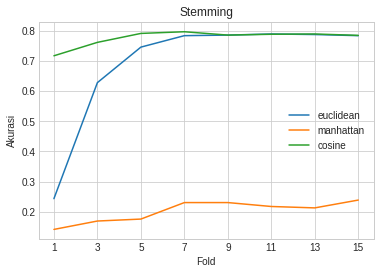

Tanpa Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
              precision    recall  f1-score   support

           0       0.33      0.02      0.04        90
           1       0.81      0.19      0.31        90
           2       0.81      0.29      0.43        90
           3       0.79      0.21      0.33        90
           4       1.00      0.09      0.16        90
           5       0.88      0.16      0.26        90
           6       0.91      0.22      0.36        90
           7       0.62      0.09      0.16        90
           8       0.62      0.18      0.28        90
           9       0.10      0.98      0.18        90
          10       0.69      0.10      0.17        90
          11       0.77      0.19      0.30        90

    accuracy                           0.23      1080
   macro avg       0.69      0.23      0.25      1080
weighted avg       0.69      0.23      0.25      1080

akurasi= 0.2259 presisi= 0.6939 recall= 0.2259 f1= 0.3409
Tanpa Stemming

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.10      0.18        90
           2       1.00      0.16      0.27        90
           3       0.89      0.09      0.16        90
           4       1.00      0.02      0.04        90
           5       1.00      0.06      0.11        90
           6       1.00      0.09      0.16        90
           7       0.10      0.12      0.11        90
           8       0.33      0.01      0.02        90
           9       0.09      0.91      0.16        90
          10       0.00      0.00      0.00        90
          11       1.00      0.04      0.09        90

    accuracy                           0.13      1080
   macro avg       0.62      0.13      0.11      1080
weighted avg       0.62      0.13      0.11      1080

akurasi= 0.1333 presisi= 0.6179 recall= 0.1333 f1= 0.2193
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       1.00      0.12      0.22        90
           2       1.00      0.17      0.29        90
           3       0.90      0.10      0.18        90
           4       1.00      0.02      0.04        90
           5       1.00      0.10      0.18        90
           6       1.00      0.09      0.16        90
           7       0.11      0.12      0.12        90
           8       0.40      0.02      0.04        90
           9       0.09      0.91      0.16        90
          10       1.00      0.08      0.14        90
          11       1.00      0.04      0.09        90

    accuracy                           0.15      1080
   macro avg       0.71      0.15      0.14      1080
weighted avg       0.71      0.15      0.14      1080

akurasi= 0.1481 presisi= 0.7084 recall= 0.1481 f1= 0.2450
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.93      0.16      0.27        90
           2       1.00      0.12      0.22        90
           3       0.94      0.19      0.31        90
           4       1.00      0.02      0.04        90
           5       0.95      0.20      0.33        90
           6       1.00      0.07      0.12        90
           7       0.11      0.11      0.11        90
           8       0.67      0.02      0.04        90
           9       0.09      0.91      0.17        90
          10       0.88      0.08      0.14        90
          11       1.00      0.03      0.06        90

    accuracy                           0.16      1080
   macro avg       0.71      0.16      0.15      1080
weighted avg       0.71      0.16      0.15      1080

akurasi= 0.1593 presisi= 0.7137 recall= 0.1593 f1= 0.2604
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 7


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.80      0.22      0.35        90
           2       1.00      0.10      0.18        90
           3       0.92      0.12      0.22        90
           4       1.00      0.02      0.04        90
           5       0.45      0.29      0.35        90
           6       1.00      0.06      0.11        90
           7       0.18      0.10      0.13        90
           8       0.50      0.02      0.04        90
           9       0.09      0.93      0.17        90
          10       0.79      0.17      0.28        90
          11       0.00      0.00      0.00        90

    accuracy                           0.17      1080
   macro avg       0.56      0.17      0.16      1080
weighted avg       0.56      0.17      0.16      1080

akurasi= 0.1694 presisi= 0.5610 recall= 0.1694 f1= 0.2603
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.67      0.16      0.25        90
           2       1.00      0.10      0.18        90
           3       0.92      0.12      0.22        90
           4       1.00      0.03      0.06        90
           5       0.45      0.34      0.39        90
           6       1.00      0.07      0.12        90
           7       0.18      0.09      0.12        90
           8       0.60      0.03      0.06        90
           9       0.09      0.92      0.17        90
          10       0.90      0.21      0.34        90
          11       0.00      0.00      0.00        90

    accuracy                           0.17      1080
   macro avg       0.57      0.17      0.16      1080
weighted avg       0.57      0.17      0.16      1080

akurasi= 0.1731 presisi= 0.5677 recall= 0.1731 f1= 0.2654
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 11


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.74      0.19      0.30        90
           2       1.00      0.10      0.18        90
           3       0.93      0.14      0.25        90
           4       1.00      0.02      0.04        90
           5       0.33      0.39      0.36        90
           6       1.00      0.07      0.12        90
           7       0.33      0.04      0.08        90
           8       0.80      0.04      0.08        90
           9       0.10      0.91      0.17        90
          10       0.79      0.37      0.50        90
          11       0.00      0.00      0.00        90

    accuracy                           0.19      1080
   macro avg       0.58      0.19      0.17      1080
weighted avg       0.58      0.19      0.17      1080

akurasi= 0.1898 presisi= 0.5841 recall= 0.1898 f1= 0.2865
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 13


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.78      0.23      0.36        90
           2       1.00      0.09      0.16        90
           3       0.92      0.13      0.23        90
           4       1.00      0.02      0.04        90
           5       0.32      0.41      0.36        90
           6       1.00      0.06      0.11        90
           7       0.75      0.07      0.12        90
           8       1.00      0.04      0.09        90
           9       0.10      0.92      0.17        90
          10       0.84      0.34      0.49        90
          11       0.00      0.00      0.00        90

    accuracy                           0.19      1080
   macro avg       0.64      0.19      0.18      1080
weighted avg       0.64      0.19      0.18      1080

akurasi= 0.1935 presisi= 0.6420 recall= 0.1935 f1= 0.2974
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 15


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        90
           1       0.87      0.22      0.35        90
           2       1.00      0.07      0.12        90
           3       0.92      0.13      0.23        90
           4       1.00      0.02      0.04        90
           5       0.28      0.46      0.35        90
           6       1.00      0.04      0.09        90
           7       1.00      0.02      0.04        90
           8       1.00      0.03      0.06        90
           9       0.10      0.90      0.18        90
          10       0.62      0.44      0.52        90
          11       0.00      0.00      0.00        90

    accuracy                           0.20      1080
   macro avg       0.65      0.20      0.17      1080
weighted avg       0.65      0.20      0.17      1080

akurasi= 0.1954 presisi= 0.6493 recall= 0.1954 f1= 0.3004
Tanpa Stemming
Nama distance= cosine
Jumlah K tetangga= 1
              pre

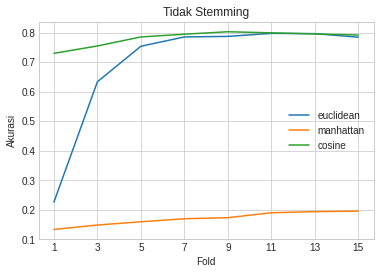

Lama Proses 30.97262692451477 seconds
CPU times: user 52 s, sys: 304 ms, total: 52.3 s
Wall time: 31 s


In [ ]:
%%time
df = pd.read_pickle('drive/MyDrive/AATABISMILLAH/NewDataset/preprocess_SWnltk_stemming.pkl')
dfNo = pd.read_pickle('drive/MyDrive/AATABISMILLAH/NewDataset/preprocess_SWnltk_nostemming.pkl')
# %%capture cap --no-stderr
start_time = time.time()
dfcount = [df,dfNo]
distancecount = ['euclidean','manhattan','cosine']
kcount = [1,3,5,7,9,11,13,15]
for x in range(2):
    arrd1 = []
    arrd2 = []
    arrd3 = []
    for y in range(len(distancecount)):
        maxresult = []
        for z in range(len(kcount)):
            if x==0:
                print('Dengan Stemming')
            else:
                print('Tanpa Stemming')
            # tempmax = classifier(dfcount[x],distancecount[y],kcount[z])
            tempmax = classi_perk(dfcount[x],distancecount[y],kcount[z])
            maxresult.append(tempmax)
            if y==0:
                arrd1.append(tempmax)
            elif y==1:
                arrd2.append(tempmax)
            elif y==2:
                arrd3.append(tempmax)
#         tapi fold yang dipakai beda beda
    plt.plot(kcount, arrd1, label = "euclidean")
    plt.plot(kcount, arrd2, label = "manhattan")
    plt.plot(kcount, arrd3, label = "cosine")
    plt.xticks(kcount)
    if x==0:
        plt.title("Stemming")
    else:
        plt.title("Tidak Stemming")
    plt.xlabel('Fold')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.pause(0.05)
plt.show
plt.style.use('seaborn-whitegrid')
print("Lama Proses %s seconds" % (time.time() - start_time))
# with open('5000_fitur_SWnltkv2.txt', 'w') as f:
#     f.write(cap.stdout)

Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
perfold= 0.8533950617283951 0.12037037037037036 0.34061488673139156
Fold ke- 1 Akurasi = 0.1204 Precision = 0.3406 Recall = 0.1204 F1-Score = 0.0801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

perfold= 0.8580246913580246 0.14814814814814817 0.5074257425742574
Fold ke- 2 Akurasi = 0.1481 Precision = 0.5074 Recall = 0.1481 F1-Score = 0.1273
perfold= 0.9320987654320989 0.5925925925925927 0.6264013764013764
Fold ke- 3 Akurasi = 0.5926 Precision = 0.6264 Recall = 0.5926 F1-Score = 0.5768
perfold= 0.8672839506172839 0.20370370370370372 0.6579787234042553
Fold ke- 4 Akurasi = 0.2037 Precision = 0.6580 Recall = 0.2037 F1-Score = 0.2038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


perfold= 0.8719135802469137 0.23148148148148148 0.6471306471306472
Fold ke- 5 Akurasi = 0.2315 Precision = 0.6471 Recall = 0.2315 F1-Score = 0.2504
perfold= 0.8842592592592594 0.3055555555555556 0.5922619047619048


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-pac

Fold ke- 6 Akurasi = 0.3056 Precision = 0.5923 Recall = 0.3056 F1-Score = 0.3219
perfold= 0.8796296296296297 0.27777777777777785 0.7173694779116465
Fold ke- 7 Akurasi = 0.2778 Precision = 0.7174 Recall = 0.2778 F1-Score = 0.3025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8688271604938271 0.212962962962963 0.7026862026862025
Fold ke- 8 Akurasi = 0.2130 Precision = 0.7027 Recall = 0.2130 F1-Score = 0.2241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


perfold= 0.8672839506172839 0.20370370370370372 0.41084229390681
Fold ke- 9 Akurasi = 0.2037 Precision = 0.4108 Recall = 0.2037 F1-Score = 0.1892
perfold= 0.868827160493827 0.212962962962963 0.5359299516908212


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold ke- 10 Akurasi = 0.2130 Precision = 0.5359 Recall = 0.2130 F1-Score = 0.2116
TP: [13, 16, 64, 22, 25, 33, 30, 23, 22, 23] TOTAL: 271
FP: [95, 92, 44, 86, 83, 75, 78, 85, 86, 85] TOTAL: 809
FN: [95, 92, 44, 86, 83, 75, 78, 85, 86, 85] TOTAL: 809
TN: [1093, 1096, 1144, 1102, 1105, 1113, 1110, 1103, 1102, 1103] TOTAL: 11071
0.25092592592592594 0.2509259259259259 0.2509259259259259 0.2509259259259259
Avg accuracyTP = 0.2509 Avg accuracy = 0.2509
Avg precisionTP= 0.2509 Avg precision= 0.5739
Avg recallTP= 0.2509 Avg recall= 0.2509
Avg f1TP= 0.2509 Avg f1= 0.2488
------------------------------------
Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 3
perfold= 0.9104938271604938 0.462962962962963 0.7095288970288971
Fold ke- 1 Akurasi = 0.4630 Precision = 0.7095 Recall = 0.4630 F1-Score = 0.4802
perfold= 0.9166666666666666 0.49999999999999994 0.747470238095238
Fold ke- 2 Akurasi = 0.5000 Precision = 0.7475 Recall = 0.5000 F1-Score = 0.5441
perfold= 0.9444444444444445 0.666666666

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8487654320987654 0.0925925925925926 0.09034267912772585
Fold ke- 1 Akurasi = 0.0926 Precision = 0.0903 Recall = 0.0926 F1-Score = 0.0296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8503086419753085 0.10185185185185186 0.1737421383647799
Fold ke- 2 Akurasi = 0.1019 Precision = 0.1737 Recall = 0.1019 F1-Score = 0.0464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345679 0.1574074074074074 0.5908333333333333
Fold ke- 3 Akurasi = 0.1574 Precision = 0.5908 Recall = 0.1574 F1-Score = 0.1441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283949 0.12037037037037036 0.3405448717948718
Fold ke- 4 Akurasi = 0.1204 Precision = 0.3405 Recall = 0.1204 F1-Score = 0.0799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.42424242424242425
Fold ke- 5 Akurasi = 0.1667 Precision = 0.4242 Recall = 0.1667 F1-Score = 0.1495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8688271604938271 0.212962962962963 0.424645390070922
Fold ke- 6 Akurasi = 0.2130 Precision = 0.4246 Recall = 0.2130 F1-Score = 0.1979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407406 0.19444444444444442 0.5497311827956989
Fold ke- 7 Akurasi = 0.1944 Precision = 0.5497 Recall = 0.1944 F1-Score = 0.1889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.5909863945578232
Fold ke- 8 Akurasi = 0.1667 Precision = 0.5910 Recall = 0.1667 F1-Score = 0.1580


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.42401960784313725
Fold ke- 9 Akurasi = 0.1389 Precision = 0.4240 Recall = 0.1389 F1-Score = 0.1105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.452176403207331
Fold ke- 10 Akurasi = 0.1667 Precision = 0.4522 Recall = 0.1667 F1-Score = 0.1523
TP: [10, 11, 17, 13, 18, 23, 21, 18, 15, 18] TOTAL: 164
FP: [98, 97, 91, 95, 90, 85, 87, 90, 93, 90] TOTAL: 916
FN: [98, 97, 91, 95, 90, 85, 87, 90, 93, 90] TOTAL: 916
TN: [1090, 1091, 1097, 1093, 1098, 1103, 1101, 1098, 1095, 1098] TOTAL: 10964
0.15185185185185185 0.15185185185185185 0.15185185185185185 0.15185185185185185
Avg accuracyTP = 0.1519 Avg accuracy = 0.1519
Avg precisionTP= 0.1519 Avg precision= 0.4061
Avg recallTP= 0.1519 Avg recall= 0.1519
Avg f1TP= 0.1519 Avg f1= 0.1257
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8518518518518517 0.11111111111111112 0.2571428571428572
Fold ke- 1 Akurasi = 0.1111 Precision = 0.2571 Recall = 0.1111 F1-Score = 0.0632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8518518518518517 0.11111111111111112 0.2571428571428572
Fold ke- 2 Akurasi = 0.1111 Precision = 0.2571 Recall = 0.1111 F1-Score = 0.0632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407406 0.19444444444444442 0.5634502923976608
Fold ke- 3 Akurasi = 0.1944 Precision = 0.5635 Recall = 0.1944 F1-Score = 0.1945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.5073529411764706
Fold ke- 4 Akurasi = 0.1389 Precision = 0.5074 Recall = 0.1389 F1-Score = 0.1135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407406 0.19444444444444445 0.5911458333333334
Fold ke- 5 Akurasi = 0.1944 Precision = 0.5911 Recall = 0.1944 F1-Score = 0.1969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8796296296296298 0.27777777777777785 0.5919540229885057
Fold ke- 6 Akurasi = 0.2778 Precision = 0.5920 Recall = 0.2778 F1-Score = 0.2919


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074073 0.6394751082251082
Fold ke- 7 Akurasi = 0.2407 Precision = 0.6395 Recall = 0.2407 F1-Score = 0.2511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8641975308641975 0.1851851851851852 0.6743986254295532
Fold ke- 8 Akurasi = 0.1852 Precision = 0.6744 Recall = 0.1852 F1-Score = 0.1884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345679 0.1574074074074074 0.42424242424242425
Fold ke- 9 Akurasi = 0.1574 Precision = 0.4242 Recall = 0.1574 F1-Score = 0.1381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8641975308641975 0.1851851851851852 0.5494791666666666
Fold ke- 10 Akurasi = 0.1852 Precision = 0.5495 Recall = 0.1852 F1-Score = 0.1817
TP: [12, 12, 21, 15, 21, 30, 26, 20, 17, 20] TOTAL: 194
FP: [96, 96, 87, 93, 87, 78, 82, 88, 91, 88] TOTAL: 886
FN: [96, 96, 87, 93, 87, 78, 82, 88, 91, 88] TOTAL: 886
TN: [1092, 1092, 1101, 1095, 1101, 1110, 1106, 1100, 1097, 1100] TOTAL: 10994
0.1796296296296296 0.1796296296296296 0.1796296296296296 0.17962962962962958
Avg accuracyTP = 0.1796 Avg accuracy = 0.1796
Avg precisionTP= 0.1796 Avg precision= 0.5056
Avg recallTP= 0.1796 Avg recall= 0.1796
Avg f1TP= 0.1796 Avg f1= 0.1682
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8518518518518517 0.11111111111111112 0.2571428571428572
Fold ke- 1 Akurasi = 0.1111 Precision = 0.2571 Recall = 0.1111 F1-Score = 0.0632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8503086419753085 0.10185185185185186 0.17380952380952377
Fold ke- 2 Akurasi = 0.1019 Precision = 0.1738 Recall = 0.1019 F1-Score = 0.0465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8765432098765432 0.25925925925925924 0.6053240740740741
Fold ke- 3 Akurasi = 0.2593 Precision = 0.6053 Recall = 0.2593 F1-Score = 0.2726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8580246913580246 0.14814814814814817 0.5907590759075908
Fold ke- 4 Akurasi = 0.1481 Precision = 0.5908 Recall = 0.1481 F1-Score = 0.1303


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8703703703703702 0.2222222222222222 0.5913978494623656
Fold ke- 5 Akurasi = 0.2222 Precision = 0.5914 Recall = 0.2222 F1-Score = 0.2319


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.875 0.25 0.5778714107365793
Fold ke- 6 Akurasi = 0.2500 Precision = 0.5779 Recall = 0.2500 F1-Score = 0.2600


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530863 0.26851851851851855 0.7419540229885057
Fold ke- 7 Akurasi = 0.2685 Precision = 0.7420 Recall = 0.2685 F1-Score = 0.2940


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8703703703703703 0.2222222222222222 0.6581521739130435
Fold ke- 8 Akurasi = 0.2222 Precision = 0.6582 Recall = 0.2222 F1-Score = 0.2314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049383 0.12962962962962962 0.25728155339805825
Fold ke- 9 Akurasi = 0.1296 Precision = 0.2573 Recall = 0.1296 F1-Score = 0.0907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407406 0.19444444444444445 0.5078125
Fold ke- 10 Akurasi = 0.1944 Precision = 0.5078 Recall = 0.1944 F1-Score = 0.1898
TP: [12, 11, 28, 16, 24, 27, 29, 24, 14, 21] TOTAL: 206
FP: [96, 97, 80, 92, 84, 81, 79, 84, 94, 87] TOTAL: 874
FN: [96, 97, 80, 92, 84, 81, 79, 84, 94, 87] TOTAL: 874
TN: [1092, 1091, 1108, 1096, 1104, 1107, 1109, 1104, 1094, 1101] TOTAL: 11006
0.19074074074074074 0.19074074074074074 0.19074074074074074 0.19074074074074074
Avg accuracyTP = 0.1907 Avg accuracy = 0.1907
Avg precisionTP= 0.1907 Avg precision= 0.4962
Avg recallTP= 0.1907 Avg recall= 0.1907
Avg f1TP= 0.1907 Avg f1= 0.1810
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049383 0.12962962962962962 0.2873263888888889
Fold ke- 1 Akurasi = 0.1296 Precision = 0.2873 Recall = 0.1296 F1-Score = 0.1042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8580246913580246 0.14814814814814817 0.3111501431173562
Fold ke- 2 Akurasi = 0.1481 Precision = 0.3112 Recall = 0.1481 F1-Score = 0.0982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8873456790123456 0.32407407407407407 0.5727513227513227
Fold ke- 3 Akurasi = 0.3241 Precision = 0.5728 Recall = 0.3241 F1-Score = 0.3012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407408 0.19444444444444445 0.53125
Fold ke- 4 Akurasi = 0.1944 Precision = 0.5312 Recall = 0.1944 F1-Score = 0.1814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074073 0.6031653746770026
Fold ke- 5 Akurasi = 0.2407 Precision = 0.6032 Recall = 0.2407 F1-Score = 0.2493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8888888888888888 0.3333333333333333 0.5233772657181927
Fold ke- 6 Akurasi = 0.3333 Precision = 0.5234 Recall = 0.3333 F1-Score = 0.3047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.888888888888889 0.3333333333333333 0.599411231884058
Fold ke- 7 Akurasi = 0.3333 Precision = 0.5994 Recall = 0.3333 F1-Score = 0.3121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8811728395061729 0.28703703703703703 0.625
Fold ke- 8 Akurasi = 0.2870 Precision = 0.6250 Recall = 0.2870 F1-Score = 0.2879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8796296296296297 0.2777777777777778 0.446969696969697
Fold ke- 9 Akurasi = 0.2778 Precision = 0.4470 Recall = 0.2778 F1-Score = 0.2305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530867 0.2685185185185185 0.631054131054131
Fold ke- 10 Akurasi = 0.2685 Precision = 0.6311 Recall = 0.2685 F1-Score = 0.2697
TP: [14, 16, 35, 21, 26, 36, 36, 31, 30, 29] TOTAL: 274
FP: [94, 92, 73, 87, 82, 72, 72, 77, 78, 79] TOTAL: 806
FN: [94, 92, 73, 87, 82, 72, 72, 77, 78, 79] TOTAL: 806
TN: [1094, 1096, 1115, 1101, 1106, 1116, 1116, 1111, 1110, 1109] TOTAL: 11074
0.2537037037037037 0.25370370370370365 0.25370370370370365 0.25370370370370365
Avg accuracyTP = 0.2537 Avg accuracy = 0.2537
Avg precisionTP= 0.2537 Avg precision= 0.5131
Avg recallTP= 0.2537 Avg recall= 0.2537
Avg f1TP= 0.2537 Avg f1= 0.2339
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283951 0.12037037037037039 0.21493399339933994
Fold ke- 1 Akurasi = 0.1204 Precision = 0.2149 Recall = 0.1204 F1-Score = 0.0847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049383 0.12962962962962962 0.31138392857142855
Fold ke- 2 Akurasi = 0.1296 Precision = 0.3114 Recall = 0.1296 F1-Score = 0.0899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.888888888888889 0.3333333333333333 0.572654173312068
Fold ke- 3 Akurasi = 0.3333 Precision = 0.5727 Recall = 0.3333 F1-Score = 0.3130


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407408 0.19444444444444445 0.45009363295880145
Fold ke- 4 Akurasi = 0.1944 Precision = 0.4501 Recall = 0.1944 F1-Score = 0.1732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530863 0.2685185185185185 0.5170267489711934
Fold ke- 5 Akurasi = 0.2685 Precision = 0.5170 Recall = 0.2685 F1-Score = 0.2775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8842592592592592 0.3055555555555555 0.4381944444444444
Fold ke- 6 Akurasi = 0.3056 Precision = 0.4382 Recall = 0.3056 F1-Score = 0.2729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8904320987654323 0.34259259259259256 0.680077030812325
Fold ke- 7 Akurasi = 0.3426 Precision = 0.6801 Recall = 0.3426 F1-Score = 0.3271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074073 0.6158637873754153
Fold ke- 8 Akurasi = 0.2407 Precision = 0.6159 Recall = 0.2407 F1-Score = 0.2461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530863 0.2685185185185185 0.454312865497076
Fold ke- 9 Akurasi = 0.2685 Precision = 0.4543 Recall = 0.2685 F1-Score = 0.2459


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8750000000000001 0.25000000000000006 0.5468073593073592
Fold ke- 10 Akurasi = 0.2500 Precision = 0.5468 Recall = 0.2500 F1-Score = 0.2447
TP: [13, 14, 36, 21, 29, 33, 37, 26, 29, 27] TOTAL: 265
FP: [95, 94, 72, 87, 79, 75, 71, 82, 79, 81] TOTAL: 815
FN: [95, 94, 72, 87, 79, 75, 71, 82, 79, 81] TOTAL: 815
TN: [1093, 1094, 1116, 1101, 1109, 1113, 1117, 1106, 1109, 1107] TOTAL: 11065
0.24537037037037035 0.24537037037037038 0.24537037037037038 0.24537037037037038
Avg accuracyTP = 0.2454 Avg accuracy = 0.2454
Avg precisionTP= 0.2454 Avg precision= 0.4801
Avg recallTP= 0.2454 Avg recall= 0.2454
Avg f1TP= 0.2454 Avg f1= 0.2275
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049383 0.12962962962962962 0.2047895189003436
Fold ke- 1 Akurasi = 0.1296 Precision = 0.2048 Recall = 0.1296 F1-Score = 0.0890


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283951 0.12037037037037036 0.29916666666666664
Fold ke- 2 Akurasi = 0.1204 Precision = 0.2992 Recall = 0.1204 F1-Score = 0.0789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8858024691358025 0.3148148148148148 0.46789378729237224
Fold ke- 3 Akurasi = 0.3148 Precision = 0.4679 Recall = 0.3148 F1-Score = 0.2884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8672839506172839 0.20370370370370372 0.5580645161290322
Fold ke- 4 Akurasi = 0.2037 Precision = 0.5581 Recall = 0.2037 F1-Score = 0.1987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469135 0.23148148148148148 0.5352684144818977
Fold ke- 5 Akurasi = 0.2315 Precision = 0.5353 Recall = 0.2315 F1-Score = 0.2449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8811728395061729 0.28703703703703703 0.4606614929785662
Fold ke- 6 Akurasi = 0.2870 Precision = 0.4607 Recall = 0.2870 F1-Score = 0.2671


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8827160493827161 0.2962962962962963 0.632771164021164
Fold ke- 7 Akurasi = 0.2963 Precision = 0.6328 Recall = 0.2963 F1-Score = 0.2844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.875 0.25 0.6418560606060606
Fold ke- 8 Akurasi = 0.2500 Precision = 0.6419 Recall = 0.2500 F1-Score = 0.2607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074073 0.47280844155844154
Fold ke- 9 Akurasi = 0.2407 Precision = 0.4728 Recall = 0.2407 F1-Score = 0.2387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074073 0.6512841091492777
Fold ke- 10 Akurasi = 0.2407 Precision = 0.6513 Recall = 0.2407 F1-Score = 0.2477
TP: [14, 13, 34, 22, 25, 31, 32, 27, 26, 26] TOTAL: 250
FP: [94, 95, 74, 86, 83, 77, 76, 81, 82, 82] TOTAL: 830
FN: [94, 95, 74, 86, 83, 77, 76, 81, 82, 82] TOTAL: 830
TN: [1094, 1093, 1114, 1102, 1105, 1111, 1112, 1107, 1106, 1106] TOTAL: 11050
0.23148148148148148 0.23148148148148148 0.23148148148148148 0.23148148148148148
Avg accuracyTP = 0.2315 Avg accuracy = 0.2315
Avg precisionTP= 0.2315 Avg precision= 0.4925
Avg recallTP= 0.2315 Avg recall= 0.2315
Avg f1TP= 0.2315 Avg f1= 0.2198
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8580246913580248 0.14814814814814814 0.19112903225806455
Fold ke- 1 Akurasi = 0.1481 Precision = 0.1911 Recall = 0.1481 F1-Score = 0.0867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.2391251221896383
Fold ke- 2 Akurasi = 0.1389 Precision = 0.2391 Recall = 0.1389 F1-Score = 0.0882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8811728395061729 0.28703703703703703 0.5114459752519455
Fold ke- 3 Akurasi = 0.2870 Precision = 0.5114 Recall = 0.2870 F1-Score = 0.2831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345677 0.1574074074074074 0.38273195876288657
Fold ke- 4 Akurasi = 0.1574 Precision = 0.3827 Recall = 0.1574 F1-Score = 0.1278


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074073 0.5770202020202021
Fold ke- 5 Akurasi = 0.2407 Precision = 0.5770 Recall = 0.2407 F1-Score = 0.2602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8765432098765432 0.25925925925925924 0.48481116584564865
Fold ke- 6 Akurasi = 0.2593 Precision = 0.4848 Recall = 0.2593 F1-Score = 0.2401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8842592592592592 0.3055555555555555 0.6319940476190476
Fold ke- 7 Akurasi = 0.3056 Precision = 0.6320 Recall = 0.3056 F1-Score = 0.2875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8842592592592592 0.3055555555555555 0.6414381153305203
Fold ke- 8 Akurasi = 0.3056 Precision = 0.6414 Recall = 0.3056 F1-Score = 0.2989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8765432098765432 0.25925925925925924 0.4785204991087344
Fold ke- 9 Akurasi = 0.2593 Precision = 0.4785 Recall = 0.2593 F1-Score = 0.2445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.2314814814814815 0.5776862026862026
Fold ke- 10 Akurasi = 0.2315 Precision = 0.5777 Recall = 0.2315 F1-Score = 0.2342
TP: [16, 15, 31, 17, 26, 28, 33, 33, 28, 25] TOTAL: 252
FP: [92, 93, 77, 91, 82, 80, 75, 75, 80, 83] TOTAL: 828
FN: [92, 93, 77, 91, 82, 80, 75, 75, 80, 83] TOTAL: 828
TN: [1096, 1095, 1111, 1097, 1106, 1108, 1113, 1113, 1108, 1105] TOTAL: 11052
0.2333333333333333 0.2333333333333333 0.2333333333333333 0.2333333333333333
Avg accuracyTP = 0.2333 Avg accuracy = 0.2333
Avg precisionTP= 0.2333 Avg precision= 0.4716
Avg recallTP= 0.2333 Avg recall= 0.2333
Avg f1TP= 0.2333 Avg f1= 0.2151
------------------------------------
Dengan Stemming
Nama distance= manhattan
Jumlah K tetangga= 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8611111111111112 0.16666666666666666 0.19531778228532792
Fold ke- 1 Akurasi = 0.1667 Precision = 0.1953 Recall = 0.1667 F1-Score = 0.0940


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.2333333333333333
Fold ke- 2 Akurasi = 0.1667 Precision = 0.2333 Recall = 0.1667 F1-Score = 0.0906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8749999999999999 0.24999999999999997 0.5254842731108554
Fold ke- 3 Akurasi = 0.2500 Precision = 0.5255 Recall = 0.2500 F1-Score = 0.2550


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.2314814814814815 0.5102007961597003
Fold ke- 4 Akurasi = 0.2315 Precision = 0.5102 Recall = 0.2315 F1-Score = 0.1839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530863 0.2685185185185185 0.5766828336272781
Fold ke- 5 Akurasi = 0.2685 Precision = 0.5767 Recall = 0.2685 F1-Score = 0.2797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.881172839506173 0.28703703703703703 0.45444444444444443
Fold ke- 6 Akurasi = 0.2870 Precision = 0.4544 Recall = 0.2870 F1-Score = 0.2353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8873456790123456 0.32407407407407407 0.5926801384254109
Fold ke- 7 Akurasi = 0.3241 Precision = 0.5927 Recall = 0.3241 F1-Score = 0.2742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8842592592592592 0.3055555555555555 0.617652329749104
Fold ke- 8 Akurasi = 0.3056 Precision = 0.6177 Recall = 0.3056 F1-Score = 0.2743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8873456790123457 0.32407407407407407 0.5400362318840579
Fold ke- 9 Akurasi = 0.3241 Precision = 0.5400 Recall = 0.3241 F1-Score = 0.2986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530865 0.26851851851851855 0.6212462462462462
Fold ke- 10 Akurasi = 0.2685 Precision = 0.6212 Recall = 0.2685 F1-Score = 0.2469
TP: [18, 18, 27, 25, 29, 31, 35, 33, 35, 29] TOTAL: 280
FP: [90, 90, 81, 83, 79, 77, 73, 75, 73, 79] TOTAL: 800
FN: [90, 90, 81, 83, 79, 77, 73, 75, 73, 79] TOTAL: 800
TN: [1098, 1098, 1107, 1105, 1109, 1111, 1115, 1113, 1115, 1109] TOTAL: 11080
0.25925925925925924 0.25925925925925924 0.25925925925925924 0.25925925925925924
Avg accuracyTP = 0.2593 Avg accuracy = 0.2593
Avg precisionTP= 0.2593 Avg precision= 0.4867
Avg recallTP= 0.2593 Avg recall= 0.2593
Avg f1TP= 0.2593 Avg f1= 0.2232
------------------------------------
Dengan Stemming
Nama distance= cosine
Jumlah K tetangga= 1
perfold= 0.9382716049382714 0.6296296296296297 0.6531204906204906
Fold ke- 1 Akurasi = 0.6296 Precision = 0.6531 Recall = 0.6296 F1-Score = 0.6190
perfold= 0.933641975308642 0.601851851851852 0.6079982517482517
Fold ke- 2 Akurasi = 0.6019 Precision = 0.6080 Recall 

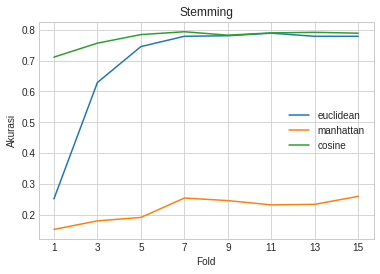

Tanpa Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
perfold= 0.8503086419753085 0.10185185185185186 0.1737421383647799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold ke- 1 Akurasi = 0.1019 Precision = 0.1737 Recall = 0.1019 F1-Score = 0.0464
perfold= 0.8533950617283951 0.12037037037037036 0.3405448717948718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold ke- 2 Akurasi = 0.1204 Precision = 0.3405 Recall = 0.1204 F1-Score = 0.0799
perfold= 0.9351851851851855 0.6111111111111112 0.6375712658800894
Fold ke- 3 Akurasi = 0.6111 Precision = 0.6376 Recall = 0.6111 F1-Score = 0.6007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


perfold= 0.8641975308641975 0.1851851851851852 0.5744791666666667
Fold ke- 4 Akurasi = 0.1852 Precision = 0.5745 Recall = 0.1852 F1-Score = 0.1755


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


perfold= 0.8703703703703702 0.22222222222222224 0.563707729468599
Fold ke- 5 Akurasi = 0.2222 Precision = 0.5637 Recall = 0.2222 F1-Score = 0.2318
perfold= 0.8765432098765432 0.2592592592592593 0.5084269662921348
Fold ke- 6 Akurasi = 0.2593 Precision = 0.5084 Recall = 0.2593 F1-Score = 0.2636


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.2314814814814815 0.6393793472445157
Fold ke- 7 Akurasi = 0.2315 Precision = 0.6394 Recall = 0.2315 F1-Score = 0.2395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407408 0.19444444444444445 0.6329787234042553
Fold ke- 8 Akurasi = 0.1944 Precision = 0.6330 Recall = 0.1944 F1-Score = 0.1987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407408 0.19444444444444442 0.4245614035087719
Fold ke- 9 Akurasi = 0.1944 Precision = 0.4246 Recall = 0.1944 F1-Score = 0.1792


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407406 0.19444444444444445 0.5357565011820331
Fold ke- 10 Akurasi = 0.1944 Precision = 0.5358 Recall = 0.1944 F1-Score = 0.1903
TP: [11, 13, 66, 20, 24, 28, 25, 21, 21, 21] TOTAL: 250
FP: [97, 95, 42, 88, 84, 80, 83, 87, 87, 87] TOTAL: 830
FN: [97, 95, 42, 88, 84, 80, 83, 87, 87, 87] TOTAL: 830
TN: [1091, 1093, 1146, 1100, 1104, 1108, 1105, 1101, 1101, 1101] TOTAL: 11050
0.2314814814814815 0.23148148148148154 0.23148148148148154 0.23148148148148154
Avg accuracyTP = 0.2315 Avg accuracy = 0.2315
Avg precisionTP= 0.2315 Avg precision= 0.5031
Avg recallTP= 0.2315 Avg recall= 0.2315
Avg f1TP= 0.2315 Avg f1= 0.2206
------------------------------------
Tanpa Stemming
Nama distance= euclidean
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.9182098765432101 0.5092592592592592 0.6881258111210942
Fold ke- 1 Akurasi = 0.5093 Precision = 0.6881 Recall = 0.5093 F1-Score = 0.5259
perfold= 0.9243827160493828 0.5462962962962962 0.7381613756613756
Fold ke- 2 Akurasi = 0.5463 Precision = 0.7382 Recall = 0.5463 F1-Score = 0.5768
perfold= 0.9429012345679012 0.6574074074074073 0.6625666000666001
Fold ke- 3 Akurasi = 0.6574 Precision = 0.6626 Recall = 0.6574 F1-Score = 0.6424
perfold= 0.9351851851851852 0.6111111111111112 0.8130926943426943
Fold ke- 4 Akurasi = 0.6111 Precision = 0.8131 Recall = 0.6111 F1-Score = 0.6467
perfold= 0.947530864197531 0.6851851851851851 0.8461309523809523
Fold ke- 5 Akurasi = 0.6852 Precision = 0.8461 Recall = 0.6852 F1-Score = 0.7280
perfold= 0.9506172839506172 0.7037037037037037 0.8699074074074075
Fold ke- 6 Akurasi = 0.7037 Precision = 0.8699 Recall = 0.7037 F1-Score = 0.7361
perfold= 0.9537037037037037 0.7222222222222222 0.8883769586894587
Fold ke- 7 Akurasi = 0.7222 Precision = 0.8884 Recall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8487654320987654 0.0925925925925926 0.09034267912772585
Fold ke- 1 Akurasi = 0.0926 Precision = 0.0903 Recall = 0.0926 F1-Score = 0.0296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8503086419753085 0.10185185185185186 0.1737421383647799
Fold ke- 2 Akurasi = 0.1019 Precision = 0.1737 Recall = 0.1019 F1-Score = 0.0464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049383 0.12962962962962965 0.42401960784313725
Fold ke- 3 Akurasi = 0.1296 Precision = 0.4240 Recall = 0.1296 F1-Score = 0.0968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283949 0.12037037037037036 0.3405448717948718
Fold ke- 4 Akurasi = 0.1204 Precision = 0.3405 Recall = 0.1204 F1-Score = 0.0799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345677 0.1574074074074074 0.42416666666666664
Fold ke- 5 Akurasi = 0.1574 Precision = 0.4242 Recall = 0.1574 F1-Score = 0.1380


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8672839506172839 0.20370370370370372 0.4245614035087719
Fold ke- 6 Akurasi = 0.2037 Precision = 0.4246 Recall = 0.2037 F1-Score = 0.1906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8626543209876543 0.17592592592592593 0.5493986254295532
Fold ke- 7 Akurasi = 0.1759 Precision = 0.5494 Recall = 0.1759 F1-Score = 0.1702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.5909090909090909
Fold ke- 8 Akurasi = 0.1667 Precision = 0.5909 Recall = 0.1667 F1-Score = 0.1578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.42401960784313725
Fold ke- 9 Akurasi = 0.1389 Precision = 0.4240 Recall = 0.1389 F1-Score = 0.1105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.3408333333333333
Fold ke- 10 Akurasi = 0.1389 Precision = 0.3408 Recall = 0.1389 F1-Score = 0.1077
TP: [10, 11, 14, 13, 17, 22, 19, 18, 15, 15] TOTAL: 154
FP: [98, 97, 94, 95, 91, 86, 89, 90, 93, 93] TOTAL: 926
FN: [98, 97, 94, 95, 91, 86, 89, 90, 93, 93] TOTAL: 926
TN: [1090, 1091, 1094, 1093, 1097, 1102, 1099, 1098, 1095, 1095] TOTAL: 10954
0.1425925925925926 0.14259259259259258 0.14259259259259258 0.14259259259259258
Avg accuracyTP = 0.1426 Avg accuracy = 0.1426
Avg precisionTP= 0.1426 Avg precision= 0.3783
Avg recallTP= 0.1426 Avg recall= 0.1426
Avg f1TP= 0.1426 Avg f1= 0.1128
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8487654320987654 0.0925925925925926 0.09034267912772585
Fold ke- 1 Akurasi = 0.0926 Precision = 0.0903 Recall = 0.0926 F1-Score = 0.0296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8503086419753085 0.10185185185185186 0.1737421383647799
Fold ke- 2 Akurasi = 0.1019 Precision = 0.1737 Recall = 0.1019 F1-Score = 0.0464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407408 0.19444444444444445 0.5495614035087719
Fold ke- 3 Akurasi = 0.1944 Precision = 0.5496 Recall = 0.1944 F1-Score = 0.1955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049382 0.12962962962962962 0.4239482200647249
Fold ke- 4 Akurasi = 0.1296 Precision = 0.4239 Recall = 0.1296 F1-Score = 0.0967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.42424242424242425
Fold ke- 5 Akurasi = 0.1667 Precision = 0.4242 Recall = 0.1667 F1-Score = 0.1495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469135 0.2314814814814815 0.5081521739130435
Fold ke- 6 Akurasi = 0.2315 Precision = 0.5082 Recall = 0.2315 F1-Score = 0.2350


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8688271604938271 0.212962962962963 0.6469534050179211
Fold ke- 7 Akurasi = 0.2130 Precision = 0.6470 Recall = 0.2130 F1-Score = 0.2251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.5909090909090909
Fold ke- 8 Akurasi = 0.1667 Precision = 0.5909 Recall = 0.1667 F1-Score = 0.1578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.42401960784313725
Fold ke- 9 Akurasi = 0.1389 Precision = 0.4240 Recall = 0.1389 F1-Score = 0.1105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8580246913580246 0.14814814814814817 0.3408333333333333
Fold ke- 10 Akurasi = 0.1481 Precision = 0.3408 Recall = 0.1481 F1-Score = 0.1191
TP: [10, 11, 21, 14, 18, 25, 23, 18, 15, 16] TOTAL: 171
FP: [98, 97, 87, 94, 90, 83, 85, 90, 93, 92] TOTAL: 909
FN: [98, 97, 87, 94, 90, 83, 85, 90, 93, 92] TOTAL: 909
TN: [1090, 1091, 1101, 1094, 1098, 1105, 1103, 1098, 1095, 1096] TOTAL: 10971
0.15833333333333335 0.15833333333333333 0.15833333333333333 0.15833333333333333
Avg accuracyTP = 0.1583 Avg accuracy = 0.1583
Avg precisionTP= 0.1583 Avg precision= 0.4173
Avg recallTP= 0.1583 Avg recall= 0.1583
Avg f1TP= 0.1583 Avg f1= 0.1365
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8503086419753085 0.10185185185185186 0.1737421383647799
Fold ke- 1 Akurasi = 0.1019 Precision = 0.1737 Recall = 0.1019 F1-Score = 0.0464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8503086419753085 0.10185185185185186 0.17380952380952377
Fold ke- 2 Akurasi = 0.1019 Precision = 0.1738 Recall = 0.1019 F1-Score = 0.0465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469135 0.2314814814814815 0.6125936329588014
Fold ke- 3 Akurasi = 0.2315 Precision = 0.6126 Recall = 0.2315 F1-Score = 0.2430


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049382 0.12962962962962962 0.4239482200647249
Fold ke- 4 Akurasi = 0.1296 Precision = 0.4239 Recall = 0.1296 F1-Score = 0.0967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8626543209876543 0.17592592592592593 0.5076530612244898
Fold ke- 5 Akurasi = 0.1759 Precision = 0.5077 Recall = 0.1759 F1-Score = 0.1663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469135 0.2314814814814815 0.5081521739130435
Fold ke- 6 Akurasi = 0.2315 Precision = 0.5082 Recall = 0.2315 F1-Score = 0.2332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074078 0.6583333333333333
Fold ke- 7 Akurasi = 0.2407 Precision = 0.6583 Recall = 0.2407 F1-Score = 0.2496


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8641975308641975 0.1851851851851852 0.6743986254295532
Fold ke- 8 Akurasi = 0.1852 Precision = 0.6744 Recall = 0.1852 F1-Score = 0.1861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8549382716049383 0.12962962962962962 0.25728155339805825
Fold ke- 9 Akurasi = 0.1296 Precision = 0.2573 Recall = 0.1296 F1-Score = 0.0907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345677 0.1574074074074074 0.42416666666666664
Fold ke- 10 Akurasi = 0.1574 Precision = 0.4242 Recall = 0.1574 F1-Score = 0.1317
TP: [11, 11, 25, 14, 19, 25, 26, 20, 14, 17] TOTAL: 182
FP: [97, 97, 83, 94, 89, 83, 82, 88, 94, 91] TOTAL: 898
FN: [97, 97, 83, 94, 89, 83, 82, 88, 94, 91] TOTAL: 898
TN: [1091, 1091, 1105, 1094, 1099, 1105, 1106, 1100, 1094, 1097] TOTAL: 10982
0.1685185185185185 0.1685185185185185 0.1685185185185185 0.1685185185185185
Avg accuracyTP = 0.1685 Avg accuracy = 0.1685
Avg precisionTP= 0.1685 Avg precision= 0.4414
Avg recallTP= 0.1685 Avg recall= 0.1685
Avg f1TP= 0.1685 Avg f1= 0.1490
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8518518518518517 0.11111111111111112 0.17380952380952377
Fold ke- 1 Akurasi = 0.1111 Precision = 0.1738 Recall = 0.1111 F1-Score = 0.0601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8487654320987654 0.0925925925925926 0.09034267912772585
Fold ke- 2 Akurasi = 0.0926 Precision = 0.0903 Recall = 0.0926 F1-Score = 0.0296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8796296296296297 0.27777777777777785 0.5132936507936509
Fold ke- 3 Akurasi = 0.2778 Precision = 0.5133 Recall = 0.2778 F1-Score = 0.2623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.5073529411764706
Fold ke- 4 Akurasi = 0.1389 Precision = 0.5074 Recall = 0.1389 F1-Score = 0.1135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407406 0.19444444444444445 0.5078125
Fold ke- 5 Akurasi = 0.1944 Precision = 0.5078 Recall = 0.1944 F1-Score = 0.1893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074078 0.406575114440283
Fold ke- 6 Akurasi = 0.2407 Precision = 0.4066 Recall = 0.2407 F1-Score = 0.2218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.875 0.25 0.6473158551810236
Fold ke- 7 Akurasi = 0.2500 Precision = 0.6473 Recall = 0.2500 F1-Score = 0.2662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8657407407407408 0.19444444444444445 0.6744791666666666
Fold ke- 8 Akurasi = 0.1944 Precision = 0.6745 Recall = 0.1944 F1-Score = 0.1959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814815 0.1388888888888889 0.4240924092409241
Fold ke- 9 Akurasi = 0.1389 Precision = 0.4241 Recall = 0.1389 F1-Score = 0.1106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8626543209876543 0.17592592592592593 0.5076530612244898
Fold ke- 10 Akurasi = 0.1759 Precision = 0.5077 Recall = 0.1759 F1-Score = 0.1663
TP: [12, 10, 30, 15, 21, 26, 27, 21, 15, 19] TOTAL: 196
FP: [96, 98, 78, 93, 87, 82, 81, 87, 93, 89] TOTAL: 884
FN: [96, 98, 78, 93, 87, 82, 81, 87, 93, 89] TOTAL: 884
TN: [1092, 1090, 1110, 1095, 1101, 1106, 1107, 1101, 1095, 1099] TOTAL: 10996
0.1814814814814815 0.1814814814814815 0.1814814814814815 0.18148148148148152
Avg accuracyTP = 0.1815 Avg accuracy = 0.1815
Avg precisionTP= 0.1815 Avg precision= 0.4453
Avg recallTP= 0.1815 Avg recall= 0.1815
Avg f1TP= 0.1815 Avg f1= 0.1616
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8518518518518517 0.11111111111111112 0.17380952380952377
Fold ke- 1 Akurasi = 0.1111 Precision = 0.1738 Recall = 0.1111 F1-Score = 0.0601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8487654320987654 0.0925925925925926 0.09034267912772585
Fold ke- 2 Akurasi = 0.0926 Precision = 0.0903 Recall = 0.0926 F1-Score = 0.0296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8811728395061728 0.28703703703703703 0.5636443803110469
Fold ke- 3 Akurasi = 0.2870 Precision = 0.5636 Recall = 0.2870 F1-Score = 0.2885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8580246913580246 0.14814814814814814 0.5074257425742574
Fold ke- 4 Akurasi = 0.1481 Precision = 0.5074 Recall = 0.1481 F1-Score = 0.1273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.867283950617284 0.20370370370370372 0.5078947368421053
Fold ke- 5 Akurasi = 0.2037 Precision = 0.5079 Recall = 0.2037 F1-Score = 0.2013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074073 0.4249084249084249
Fold ke- 6 Akurasi = 0.2407 Precision = 0.4249 Recall = 0.2407 F1-Score = 0.2278


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074073 0.5638888888888888
Fold ke- 7 Akurasi = 0.2407 Precision = 0.5639 Recall = 0.2407 F1-Score = 0.2423


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.867283950617284 0.20370370370370372 0.6745614035087719
Fold ke- 8 Akurasi = 0.2037 Precision = 0.6746 Recall = 0.2037 F1-Score = 0.2096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8611111111111112 0.16666666666666666 0.5076530612244898
Fold ke- 9 Akurasi = 0.1667 Precision = 0.5077 Recall = 0.1667 F1-Score = 0.1549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.867283950617284 0.20370370370370372 0.5912280701754385
Fold ke- 10 Akurasi = 0.2037 Precision = 0.5912 Recall = 0.2037 F1-Score = 0.2061
TP: [12, 10, 31, 16, 22, 26, 26, 22, 18, 22] TOTAL: 205
FP: [96, 98, 77, 92, 86, 82, 82, 86, 90, 86] TOTAL: 875
FN: [96, 98, 77, 92, 86, 82, 82, 86, 90, 86] TOTAL: 875
TN: [1092, 1090, 1111, 1096, 1102, 1106, 1106, 1102, 1098, 1102] TOTAL: 11005
0.1898148148148148 0.18981481481481483 0.18981481481481483 0.18981481481481483
Avg accuracyTP = 0.1898 Avg accuracy = 0.1898
Avg precisionTP= 0.1898 Avg precision= 0.4605
Avg recallTP= 0.1898 Avg recall= 0.1898
Avg f1TP= 0.1898 Avg f1= 0.1748
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283951 0.12037037037037039 0.2572115384615385
Fold ke- 1 Akurasi = 0.1204 Precision = 0.2572 Recall = 0.1204 F1-Score = 0.0769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283952 0.12037037037037036 0.29901960784313725
Fold ke- 2 Akurasi = 0.1204 Precision = 0.2990 Recall = 0.1204 F1-Score = 0.0787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.875 0.25000000000000006 0.5903985507246378
Fold ke- 3 Akurasi = 0.2500 Precision = 0.5904 Recall = 0.2500 F1-Score = 0.2597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345679 0.1574074074074074 0.4522569444444444
Fold ke- 4 Akurasi = 0.1574 Precision = 0.4523 Recall = 0.1574 F1-Score = 0.1335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8765432098765432 0.25925925925925924 0.575189393939394
Fold ke- 5 Akurasi = 0.2593 Precision = 0.5752 Recall = 0.2593 F1-Score = 0.2696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8765432098765434 0.25925925925925924 0.4159301346801347
Fold ke- 6 Akurasi = 0.2593 Precision = 0.4159 Recall = 0.2593 F1-Score = 0.2377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530863 0.26851851851851855 0.6475095785440613
Fold ke- 7 Akurasi = 0.2685 Precision = 0.6475 Recall = 0.2685 F1-Score = 0.2737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8703703703703703 0.2222222222222222 0.6471306471306472
Fold ke- 8 Akurasi = 0.2222 Precision = 0.6471 Recall = 0.2222 F1-Score = 0.2244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8688271604938271 0.212962962962963 0.49417562724014336
Fold ke- 9 Akurasi = 0.2130 Precision = 0.4942 Recall = 0.2130 F1-Score = 0.2059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.2314814814814815 0.5914855072463768
Fold ke- 10 Akurasi = 0.2315 Precision = 0.5915 Recall = 0.2315 F1-Score = 0.2434
TP: [13, 13, 27, 17, 28, 28, 29, 24, 23, 25] TOTAL: 227
FP: [95, 95, 81, 91, 80, 80, 79, 84, 85, 83] TOTAL: 853
FN: [95, 95, 81, 91, 80, 80, 79, 84, 85, 83] TOTAL: 853
TN: [1093, 1093, 1107, 1097, 1108, 1108, 1109, 1104, 1103, 1105] TOTAL: 11027
0.21018518518518517 0.2101851851851852 0.2101851851851852 0.21018518518518522
Avg accuracyTP = 0.2102 Avg accuracy = 0.2102
Avg precisionTP= 0.2102 Avg precision= 0.4970
Avg recallTP= 0.2102 Avg recall= 0.2102
Avg f1TP= 0.2102 Avg f1= 0.2003
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814814 0.1388888888888889 0.23674242424242423
Fold ke- 1 Akurasi = 0.1389 Precision = 0.2367 Recall = 0.1389 F1-Score = 0.0993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8564814814814815 0.1388888888888889 0.38242574257425743
Fold ke- 2 Akurasi = 0.1389 Precision = 0.3824 Recall = 0.1389 F1-Score = 0.1091


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234568 0.24074074074074078 0.5017821285140562
Fold ke- 3 Akurasi = 0.2407 Precision = 0.5018 Recall = 0.2407 F1-Score = 0.2449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8595679012345677 0.1574074074074074 0.5075
Fold ke- 4 Akurasi = 0.1574 Precision = 0.5075 Recall = 0.1574 F1-Score = 0.1410


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.23148148148148148 0.49642857142857144
Fold ke- 5 Akurasi = 0.2315 Precision = 0.4964 Recall = 0.2315 F1-Score = 0.2246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074078 0.41574074074074074
Fold ke- 6 Akurasi = 0.2407 Precision = 0.4157 Recall = 0.2407 F1-Score = 0.2195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8811728395061729 0.28703703703703703 0.6359126984126983
Fold ke- 7 Akurasi = 0.2870 Precision = 0.6359 Recall = 0.2870 F1-Score = 0.2950


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.2314814814814815 0.6511904761904762
Fold ke- 8 Akurasi = 0.2315 Precision = 0.6512 Recall = 0.2315 F1-Score = 0.2322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.875 0.25000000000000006 0.5916666666666667
Fold ke- 9 Akurasi = 0.2500 Precision = 0.5917 Recall = 0.2500 F1-Score = 0.2575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8719135802469137 0.2314814814814815 0.5914855072463768
Fold ke- 10 Akurasi = 0.2315 Precision = 0.5915 Recall = 0.2315 F1-Score = 0.2434
TP: [15, 15, 26, 17, 25, 26, 31, 25, 27, 25] TOTAL: 232
FP: [93, 93, 82, 91, 83, 82, 77, 83, 81, 83] TOTAL: 848
FN: [93, 93, 82, 91, 83, 82, 77, 83, 81, 83] TOTAL: 848
TN: [1095, 1095, 1106, 1097, 1105, 1106, 1111, 1105, 1107, 1105] TOTAL: 11032
0.2148148148148148 0.2148148148148148 0.2148148148148148 0.2148148148148148
Avg accuracyTP = 0.2148 Avg accuracy = 0.2148
Avg precisionTP= 0.2148 Avg precision= 0.5011
Avg recallTP= 0.2148 Avg recall= 0.2148
Avg f1TP= 0.2148 Avg f1= 0.2067
------------------------------------
Tanpa Stemming
Nama distance= manhattan
Jumlah K tetangga= 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8611111111111112 0.16666666666666666 0.2056372549019608
Fold ke- 1 Akurasi = 0.1667 Precision = 0.2056 Recall = 0.1667 F1-Score = 0.1138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8533950617283951 0.12037037037037039 0.20209750566893425
Fold ke- 2 Akurasi = 0.1204 Precision = 0.2021 Recall = 0.1204 F1-Score = 0.0696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8688271604938271 0.212962962962963 0.5214646464646465
Fold ke- 3 Akurasi = 0.2130 Precision = 0.5215 Recall = 0.2130 F1-Score = 0.2123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.861111111111111 0.16666666666666666 0.4743986254295532
Fold ke- 4 Akurasi = 0.1667 Precision = 0.4744 Recall = 0.1667 F1-Score = 0.1468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.867283950617284 0.20370370370370372 0.5078947368421053
Fold ke- 5 Akurasi = 0.2037 Precision = 0.5079 Recall = 0.2037 F1-Score = 0.2013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074073 0.41111111111111115
Fold ke- 6 Akurasi = 0.2407 Precision = 0.4111 Recall = 0.2407 F1-Score = 0.2186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8858024691358025 0.3148148148148148 0.6325997314921366
Fold ke- 7 Akurasi = 0.3148 Precision = 0.6326 Recall = 0.3148 F1-Score = 0.3068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8749999999999999 0.25 0.6420542635658915
Fold ke- 8 Akurasi = 0.2500 Precision = 0.6421 Recall = 0.2500 F1-Score = 0.2416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8780864197530863 0.26851851851851855 0.5540674603174603
Fold ke- 9 Akurasi = 0.2685 Precision = 0.5541 Recall = 0.2685 F1-Score = 0.2509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


perfold= 0.8734567901234569 0.24074074074074073 0.5915750915750916
Fold ke- 10 Akurasi = 0.2407 Precision = 0.5916 Recall = 0.2407 F1-Score = 0.2518
TP: [18, 13, 23, 18, 22, 26, 34, 27, 29, 26] TOTAL: 236
FP: [90, 95, 85, 90, 86, 82, 74, 81, 79, 82] TOTAL: 844
FN: [90, 95, 85, 90, 86, 82, 74, 81, 79, 82] TOTAL: 844
TN: [1098, 1093, 1103, 1098, 1102, 1106, 1114, 1107, 1109, 1106] TOTAL: 11036
0.21851851851851853 0.21851851851851856 0.21851851851851856 0.21851851851851856
Avg accuracyTP = 0.2185 Avg accuracy = 0.2185
Avg precisionTP= 0.2185 Avg precision= 0.4743
Avg recallTP= 0.2185 Avg recall= 0.2185
Avg f1TP= 0.2185 Avg f1= 0.2014
------------------------------------
Tanpa Stemming
Nama distance= cosine
Jumlah K tetangga= 1
perfold= 0.9382716049382717 0.6296296296296297 0.6393909331409331
Fold ke- 1 Akurasi = 0.6296 Precision = 0.6394 Recall = 0.6296 F1-Score = 0.6189
perfold= 0.9506172839506174 0.7037037037037037 0.7147269397269397
Fold ke- 2 Akurasi = 0.7037 Precision = 0.7147 Recall

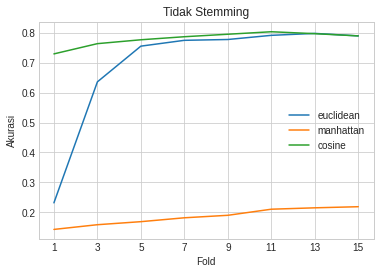

Lama Proses 141.36977338790894 seconds
CPU times: user 3min 26s, sys: 1.73 s, total: 3min 28s
Wall time: 2min 21s


In [ ]:
%%time
df = pd.read_pickle('drive/MyDrive/AATABISMILLAH/NewDataset/preprocess_SWnltk_stemming.pkl')
dfNo = pd.read_pickle('drive/MyDrive/AATABISMILLAH/NewDataset/preprocess_SWnltk_nostemming.pkl')
# %%capture cap --no-stderr
start_time = time.time()
dfcount = [df,dfNo]
distancecount = ['euclidean','manhattan','cosine']
kcount = [1,3,5,7,9,11,13,15]
for x in range(2):
    arrd1 = []
    arrd2 = []
    arrd3 = []
    for y in range(len(distancecount)):
        maxresult = []
        for z in range(len(kcount)):
            if x==0:
                print('Dengan Stemming')
            else:
                print('Tanpa Stemming')
            tempmax = classifier(dfcount[x],distancecount[y],kcount[z])
            maxresult.append(tempmax)
            if y==0:
                arrd1.append(tempmax)
            elif y==1:
                arrd2.append(tempmax)
            elif y==2:
                arrd3.append(tempmax)
#         tapi fold yang dipakai beda beda
    plt.plot(kcount, arrd1, label = "euclidean")
    plt.plot(kcount, arrd2, label = "manhattan")
    plt.plot(kcount, arrd3, label = "cosine")
    plt.xticks(kcount)
    if x==0:
        plt.title("Stemming")
    else:
        plt.title("Tidak Stemming")
    plt.xlabel('Fold')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.pause(0.05)
plt.show
plt.style.use('seaborn-whitegrid')
print("Lama Proses %s seconds" % (time.time() - start_time))
# with open('5000_fitur_SWnltkv2.txt', 'w') as f:
#     f.write(cap.stdout)

## coba

In [ ]:
X = df['text']
y = df['label'].astype('int')
# X = dfNo['text']
# y = dfNo['label'].astype('int')

In [ ]:
vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
# vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [ ]:
from sklearn.model_selection import GridSearchCV
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X,y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
df.head()

In [ ]:
# df['label'].head(216).unique()
df2 = df['label'].loc[:215]
df2

In [ ]:
item_counts = df2.value_counts()
print(item_counts)